In [57]:
import re
import patsy
import pickle

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics import utils

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV

import warnings
%matplotlib inline

In [58]:
def makeFormula(target, numeric=None, categoric=None, noInter = False, scale = False):
    formula = ""
    formula += target
    formula += "~"
    
    if(numeric != None):
        if scale == True:
            numeric = list(map(lambda c :  "scale(" + c + ")", numeric))
        formula_numeric = "+".join(numeric)
        formula += formula_numeric 
    
    if(numeric != None and categoric != None):
        formula += "+"
    
    if(categoric != None):
        categoric = list(map(lambda c :  "C(" + c + ")", categoric))
        formula_categoric = "+".join(categoric)
        formula += formula_categoric
    
    if(noInter == True):
        formula +="+0"
    
    return formula

In [59]:
df_train = pd.read_csv("data/train_no_missing.csv")
df_test = pd.read_csv("data/test_no_missing.csv")

nuTocaList = ["MSSubClass", "MoSold", "YrSold", "OverallQual", "OverallCond"]
df_train[nuTocaList] = df_train[nuTocaList].astype("str")
df_test[nuTocaList] = df_test[nuTocaList].astype("str")

df_all = pd.concat([df_train, df_test])
df_all.reset_index(drop = True, inplace = True)

df_all = pd.get_dummies(df_all)
df_train_dummy = df_all.iloc[:1460]
df_test_dummy = df_all.iloc[1460:]

df_train_dummy.reset_index(drop=True, inplace =True)
df_test_dummy.reset_index(drop=True, inplace =True)

df_test_dummy.drop("SalePriceLog", axis = 1, inplace = True)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
df_train.shape, df_test.shape, df_train_dummy.shape, df_test_dummy.shape

((1460, 81), (1459, 80), (1460, 351), (1459, 350))

In [61]:
#get numeric data and categoric data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_list = list(df_test.select_dtypes(include=numerics).columns)
print(len(numeric_list))

32


In [62]:
df_scale_numeric = pd.DataFrame()
# scale지정
for c in numeric_list:
    if c == "Id":
        continue
    df_scale_numeric[c+"Scale"] = scale(df_train[c])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [63]:
df_scale_numeric.drop("TotalBsmtSFScale", axis = 1, inplace = True)
df_scale_numeric.drop("GrLivAreaLogScale", axis = 1, inplace = True)

df_scale_numeric["SalePriceLog"] = df_train["SalePriceLog"]

In [64]:
numeric_list = list(df_scale_numeric.columns)
numeric_list.remove("SalePriceLog")

In [65]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, None, False), df_scale_numeric)
result = model.fit()
ttest = result.pvalues
ttest.sort_values(ascending = False, inplace = True)
ttest_list = list(ttest.index)
ttest.head(10)

OpenPorchSFScale       0.977612
GarageYrBltScale       0.833024
GarageAreaScale        0.708739
MiscValScale           0.667096
LotFrontageLogScale    0.615688
BsmtHalfBathScale      0.321010
ThreeSsnPorchScale     0.246489
HalfBathScale          0.136053
LowQualFinSFScale      0.116791
MasVnrAreaScale        0.072925
dtype: float64

In [66]:
#remove
numeric_list = ttest_list[7:-1]

In [67]:
categoric_list = list(df_train.select_dtypes(include = ["object"]).columns)
categoric_dummy_list = list(df_train_dummy.filter(regex = "_").columns)

df_scale_cate = pd.concat([df_scale_numeric, df_train[categoric_list]], axis = 1)
df_scale_cate_dummy = pd.concat([df_scale_numeric, df_train_dummy[categoric_dummy_list]], axis = 1)

len(categoric_list), len(categoric_dummy_list), df_scale_cate.shape, df_scale_cate_dummy.shape 

(48, 318, (1460, 78), (1460, 348))

In [68]:
df_one_anova_Fvalue = pd.DataFrame(columns = ["name", "Fvalue"])

for idx, c in enumerate(categoric_list):
    model = sm.OLS.from_formula("SalePriceLog ~ C({})".format(c), data=df_train)
    result = model.fit()
    df_tmp=sm.stats.anova_lm(result)
    df_one_anova_Fvalue.loc[idx] = {"name":c, "Fvalue":df_tmp['PR(>F)'][0]}   

df_one_anova_Fvalue.sort_values(by=["Fvalue"], ascending=False, inplace=True)
df_one_anova_Fvalue.reset_index(drop=True, inplace=True)
df_one_anova_Fvalue.head(8)

C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


name    Fvalue
0    Utilities  0.629609
1       YrSold  0.565639
2       MoSold  0.449661
3    LandSlope  0.338834
4       Street  0.028380
5   Condition2  0.013820
6       PoolQC  0.007695
7  MiscFeature  0.006060

In [69]:
over_one_Fvalue_list = list(df_one_anova_Fvalue[:6]["name"])
# over_one_Fvalue_list

In [70]:
over_one_Fvalue_dummy_list=[]
for c in over_one_Fvalue_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        over_one_Fvalue_dummy_list.append(a)
        
# over_one_Fvalue_dummy_list

In [71]:
# 제거 high one-way Fvalue
for c in over_one_Fvalue_list:
    categoric_list.remove(c)
    
for c in over_one_Fvalue_dummy_list:
    categoric_dummy_list.remove(c)

In [72]:
categoric_test_list = categoric_list.copy()
isLoop = True

while isLoop:
    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, categoric_test_list, True), df_scale_cate)
    result = model.fit()

    df_anova_cate = sm.stats.anova_lm(result, typ = 2)
    
    rm_idx_list = []
    max_value = df_anova_cate["PR(>F)"][0]
    tmp_idx_list = list(df_anova_cate[df_anova_cate["PR(>F)"] > 0.01].index)
    tmp_value_list = list(df_anova_cate[df_anova_cate["PR(>F)"] > 0.01].values)
    
    for idx in tmp_idx_list:
        if re.match(r'C\((\w+)\)\S*', idx):
            tmp_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", idx)
            rm_idx_list.append(tmp_index)
    
    if len(rm_idx_list) > 0:
        for idx in rm_idx_list:
            categoric_test_list.remove(idx)
            isLoop = True
    else:
        isLoop = False
    
print(categoric_test_list)
# df_ttest_cate_dummy.sort_values(by = ["t-value"], inplace = True)
# df_ttest_cate_dummy.reset_index(drop=True, inplace=True)

['Alley', 'BsmtCond', 'BsmtExposure', 'Condition1', 'Electrical', 'Exterior1st', 'Functional', 'MSZoning', 'Neighborhood', 'OverallCond', 'OverallQual', 'RoofMatl', 'SaleCondition']


In [73]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list, categoric_test_list, True), df_scale_cate)
result = model.fit()
df_anova_cate = sm.stats.anova_lm(result, typ = 2)
df_anova_cate.head()

sum_sq   df           F         PR(>F)
C(Alley)         29.533663  3.0  822.269599  3.597495e-303
C(BsmtCond)       3.530598  4.0   73.723583   1.614188e-56
C(BsmtExposure)   0.200690  4.0    4.190665   2.239016e-03
C(Condition1)     0.536220  8.0    5.598499   5.320652e-07
C(Electrical)     1.943072  4.0   40.573922   3.978035e-32

In [74]:
categoric_dummy_test_list=[]
for c in categoric_test_list:
    reg = c+"_"
    tmp = list(df_test_dummy.filter(regex = reg))
    for a in tmp:
        categoric_dummy_test_list.append(a)

In [75]:
categoric_list = categoric_test_list.copy()
categoric_dummy_list = categoric_dummy_test_list.copy()

In [76]:
numeric_test_list = numeric_list.copy()
categoric_dummy_test_list = categoric_dummy_list.copy()

In [77]:
debug = True

num_iter = 0
isLoop = True

while(isLoop):
    num_iter += 1

    model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_test_list + categoric_dummy_test_list, None, True), df_scale_cate_dummy)
    result = model.fit()

    pvalues = result.pvalues
    pvalues.sort_values(ascending = False, inplace = True)
    max_value = pvalues.values[0]
    rm_index_list = list(pvalues[pvalues > 0.01].index)
    rm_value_list = list(pvalues[pvalues > 0.01].values)
    
    if(len(rm_index_list) > 0):
        # C()제거
        rm_cate_list = []
        rm_numeric_list = []
        
        for idx in rm_index_list:
            if "_" in list(idx):
                tmp_index = re.sub(r"C\((\w+)\)\S*", r"\g<1>", idx)
                rm_cate_list.append(tmp_index)
            else:
                rm_numeric_list.append(idx)

        if len(rm_numeric_list) > 0:
            for index in rm_numeric_list:
                numeric_test_list.remove(index)
        
        if len(rm_cate_list) > 0:
            for index in rm_cate_list:
                categoric_dummy_test_list.remove(index)
        
        if debug == True:
            print("{} 단계 제거 목록: ".format(num_iter))
            for i in range(len(rm_index_list)):
                print("({}, {}) \n".format(rm_index_list[i], rm_value_list[i]), end=" ")
            print()

        isLoop = True
    else:
        isLoop = False

print("{} 시도만에 작업 끝!! : 정제된 목록 리스트 ".format(num_iter))
print("numeric list : ", numeric_test_list)
print("categoric list : ", categoric_dummy_test_list)
print("{} {} -> {} {}".format(len(numeric_list), len(categoric_dummy_list), len(numeric_test_list), len(categoric_dummy_test_list)))

1 단계 제거 목록: 
(MasVnrAreaScale, 0.9201264654035922) 
 (BedroomAbvGrScale, 0.590741221603037) 
 (OverallQual_1, 0.17726389247680407) 
 (TotRmsAbvGrdScale, 0.07140928694099372) 
 (PoolAreaScale, 0.03784414597991765) 
 (FullBathScale, 0.012252306233453452) 
 (HalfBathScale, 0.012095989504517155) 
 (LowQualFinSFScale, 0.010583730268233933) 
 
2 단계 제거 목록: 
(OverallQual_2, 0.1651790558973633) 
 (OverallQual_3, 0.015830207830898925) 
 
3 시도만에 작업 끝!! : 정제된 목록 리스트 
numeric list :  ['EnclosedPorchScale', 'WoodDeckSFScale', 'BsmtFinSF2Scale', 'BsmtFullBathScale', 'ScreenPorchScale', 'LotAreaLogScale', 'BsmtUnfSFScale', 'GarageCarsScale', 'BsmtFinSF1Scale', 'FireplacesScale', 'YearBuiltScale', 'KitchenAbvGrScale', 'YearRemodAddScale', 'SecondFlrSFScale', 'FirstFlrSFLogScale']
categoric list :  ['Alley_Grvl', 'Alley_None', 'Alley_Pave', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_None', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposur

In [78]:
numeric_list = numeric_test_list.copy()
categoric_dummy_list = categoric_dummy_test_list.copy()

# 1-2. Remove Outlier

In [79]:
model = sm.OLS.from_formula(makeFormula("SalePriceLog", numeric_list + categoric_dummy_list, None, False), df_scale_cate_dummy)
result = model.fit()

predict = result.predict(df_scale_cate_dummy).values
target = df_scale_cate_dummy["SalePriceLog"].values

# 1-2-1. Patial plot

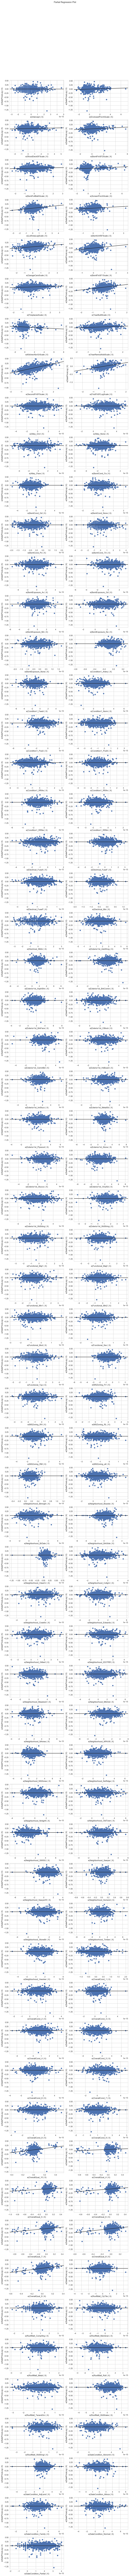

In [88]:
fig = plt.figure(figsize=(10, 200))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

# 1-2-2. Leverage - Standard residual

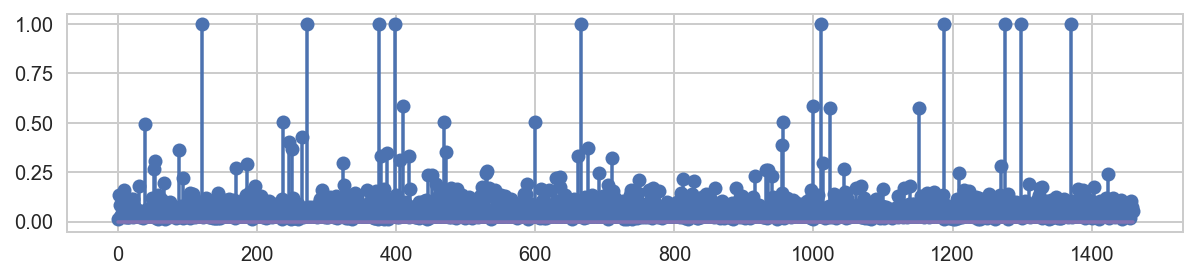

In [81]:
influence = result.get_influence()
hat = influence.hat_matrix_diag
plt.figure(figsize=(10,2))
plt.stem(hat)
plt.show()

[   8   30   39   52   53   66   88   93  120  169  185  197  237  246
  250  264  271  293  324  325  358  371  375  378  383  386  398  406
  410  418  420  446  451  457  469  471  479  488  523  529  531  533
  542  588  599  608  620  629  635  636  662  666  676  691  705  710
  711  738  749  764  769  778  812  828  859  888  916  932  934  941
  954  956  997 1000 1011 1013 1024 1044 1061 1068 1100 1130 1139 1152
 1187 1209 1216 1223 1270 1275 1298 1310 1326 1328 1370 1380 1387 1404
 1423]
99


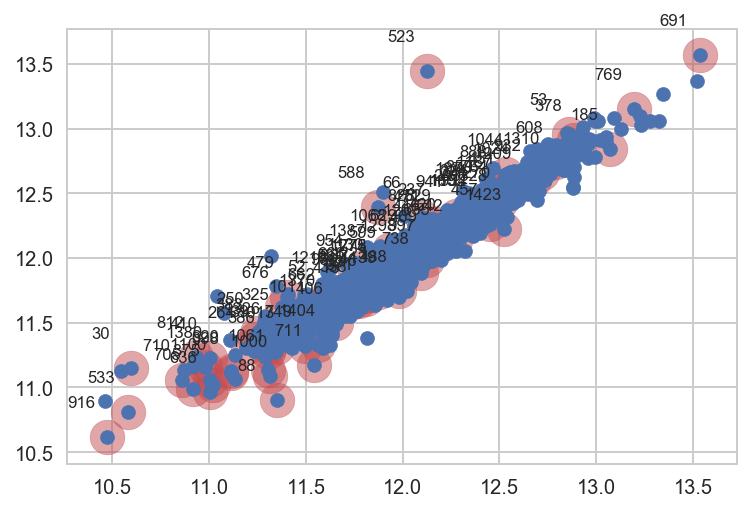

In [82]:
idx = np.where(hat > 2 * hat.mean())[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

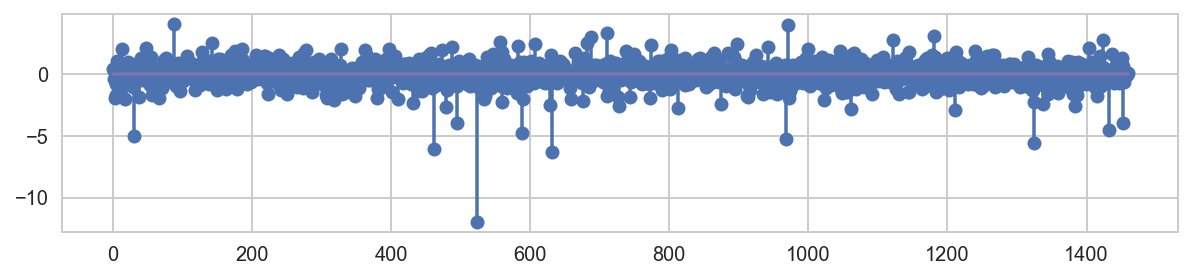

In [83]:
plt.figure(figsize=(10,2))
plt.stem(result.resid_pearson)
plt.show()

[  13   48   88  142  185  328  397  488  557  583  607  681  688  711
  774  898  942  970 1000 1122 1181 1404 1423]
23


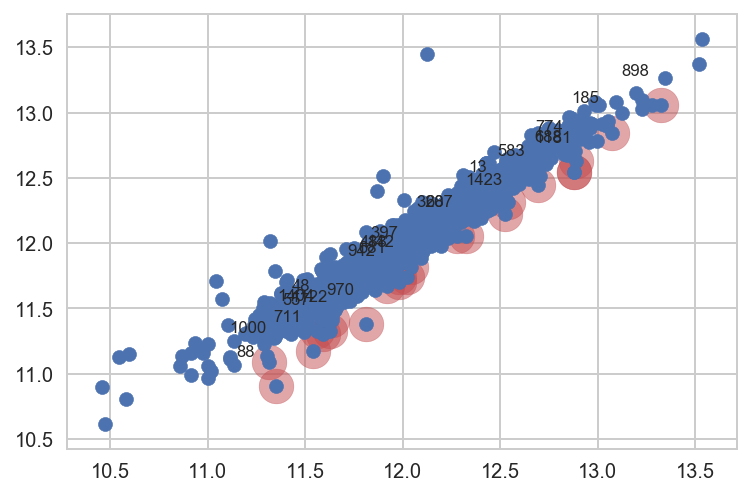

In [84]:
idx = np.where(result.resid_pearson > 2)[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

# 1-2-3. Cook`s distance

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:309: RuntimeWarning: divide by zero encountered in true_divide
  return  self.results.resid / sigma / np.sqrt(1 - hii)
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:403: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: R

[  30   88  120  271  375  398  410  523  588  676 1000 1187 1275 1370]
14


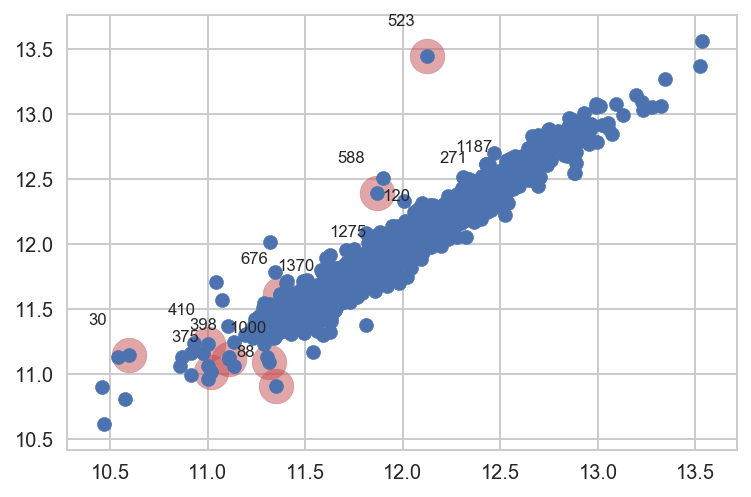

In [85]:
influence = result.get_influence()

cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(target) -len(numeric_list) +1 - 1)
idx = np.where(cooks_d2 > 0.03)[0]

ax = plt.subplot()

plt.scatter(target[idx], predict[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(target[idx], predict[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)

plt.scatter(target, predict)

print(idx)
print(len(idx))

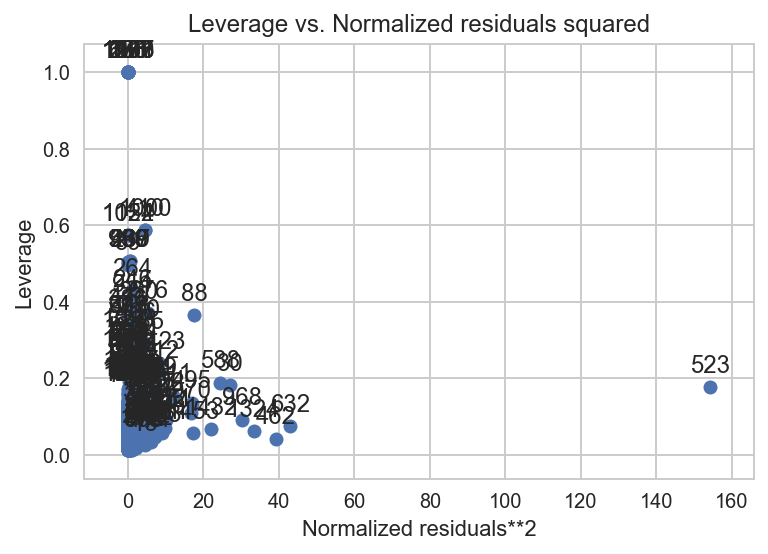

In [86]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

In [87]:
# remove outlier, 
df_scale_cate_dummy.drop([523], inplace=True)
df_scale_cate_dummy.reset_index()

index  FirstFlrSFLogScale  SecondFlrSFScale  ThreeSsnPorchScale  \
0         0           -0.803645          1.161852           -0.116339   
1         1            0.418479         -0.795163           -0.116339   
2         2           -0.576677          1.189351           -0.116339   
3         3           -0.439421          0.937276           -0.116339   
4         4            0.112127          1.617877           -0.116339   
5         5           -1.032382          0.501875           10.802446   
6         6            1.345589         -0.795163           -0.116339   
7         7            0.005860          1.457466           -0.116339   
8         8           -0.245674          0.928110           -0.116339   
9         9           -0.080643         -0.795163           -0.116339   
10       10           -0.190706         -0.795163           -0.116339   
11       11            0.212265          1.821828           -0.116339   
12       12           -0.604170         -0.795163           -0.116339   
13       13            0.949914         -0.795163           -0.116339   
14       14            0.395942         -0.795163           -0.116339   
15       15           -0.811008         -0.795163           -0.116339   
16       16           -0.301617         -0.795163           -0.116339   
17       17            0.502192         -0.795163           -0.116339   
18       18            0.025706         -0.795163           -0.116339   
19       19            0.604976         -0.795163           -0.116339   
20       20            0.147674          1.995989           -0.116339   
21       21            0.008702         -0.795163           -0.116339   
22       22            1.527988         -0.795163           -0.116339   
23       23           -0.130736         -0.795163           -0.116339   
24       24           -0.130736         -0.795163           -0.116339   
25       25            1.165790         -0.795163           -0.116339   
26       26           -0.645864         -0.795163           -0.116339   
27       27            1.364126         -0.795163           -0.116339   
28       28            1.165790         -0.795163           -0.116339   
29       29           -2.372043         -0.795163           -0.116339   
...     ...                 ...               ...                 ...   
1429   1430           -1.287593          1.734748           -0.116339   
1430   1431           -0.449264         -0.795163           -0.116339   
1431   1432           -0.416573         -0.795163           -0.116339   
1432   1433           -0.436147          1.106854           -0.116339   
1433   1434            0.059441         -0.795163           -0.116339   
1434   1435            1.039276         -0.795163           -0.116339   
1435   1436           -0.774364         -0.795163           -0.116339   
1436   1437            1.759649         -0.795163           10.256507   
1437   1438            0.352928         -0.795163           -0.116339   
1438   1439           -0.190706          0.774573           -0.116339   
1439   1440            0.796580          0.918943           -0.116339   
1440   1441           -0.833201         -0.795163           -0.116339   
1441   1442           -0.233376          1.452883           -0.116339   
1442   1443           -0.469042         -0.795163           -0.116339   
1443   1444            0.794366         -0.795163           -0.116339   
1444   1445           -0.600720         -0.795163           -0.116339   
1445   1446            0.228208         -0.795163           -0.116339   
1446   1447            0.311900          1.198517           -0.116339   
1447   1448           -1.032382          0.465209           -0.116339   
1448   1449           -1.768380         -0.795163           -0.116339   
1449   1450           -0.659886          1.258098           -0.116339   
1450   1451            1.122185         -0.795163           -0.116339   
1451   1452           -0.095293         -0.795163           -0.1